In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
print(tf.__version__)

2.14.0


# Regression with TensorFlow

We'll use the dataset from http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data to start

It's space separated and no headings so this is how to read it in

In [2]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv("auto-mpg.data", names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
                          
df.head()                    

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1

Want to build a linear regression model, to predict MPG from HorsePower, ignoring the rest

$y_{mpg} = \alpha + \beta * x_{horsepower}$

But have to clean df

In [3]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
df = df.dropna()

Going to split the dataset into a set to FIT the model and to EVALUATE the model. Train/test sets

Could do this with sklearn

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df["Horsepower"], df["MPG"], random_state=2, train_size=0.8)

In [6]:
X_train

202     95.0
184     92.0
3      150.0
176     90.0
261    120.0
       ...  
301     70.0
22      95.0
73     130.0
15      95.0
170     78.0
Name: Horsepower, Length: 313, dtype: float64

Sometimes it is useful to Normalise the data we are working with, so that the values all fall within a consistent range (if we had multiple features). Common one being StandardScaler in sklearn which makes the data have mean 0 and stddev 1

Keras also has a "layer" that we can use to build this preprocessing into the model rather than doing it manually

The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model. You create the layer and `.adapt()` it to the data:

In [7]:
from tensorflow.keras.layers.experimental import preprocessing

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(X_train.values.reshape(-1,1))
horsepower_normalizer

In [8]:
X_train.values

array([ 95.,  92., 150.,  90., 120., 115., 110.,  88., 110.,  60.,  68.,
       208.,  90., 105.,  52.,  65., 150., 225., 110., 165.,  66.,  88.,
       170.,  83.,  65., 100.,  97.,  58., 110.,  95., 103.,  88.,  65.,
       112.,  88.,  97.,  63., 170., 107.,  67., 125.,  71., 110., 198.,
        96.,  74.,  96.,  78.,  65., 105., 100.,  91.,  62.,  67.,  95.,
        86.,  68., 150., 160., 139.,  52.,  88., 130., 100.,  67.,  67.,
       180.,  86.,  90., 150., 100., 158.,  65.,  75., 113.,  75., 165.,
        71., 153.,  85.,  84.,  60., 140., 170.,  67.,  90.,  95., 150.,
       149.,  75.,  72.,  83., 220.,  98.,  71., 150.,  95.,  80.,  72.,
       150., 110.,  88., 137., 153.,  95., 102., 120.,  88.,  70., 100.,
        78.,  72.,  65., 167., 180., 170., 100., 150., 116., 105.,  75.,
        48., 110.,  90., 140.,  67., 215.,  46., 105., 198.,  71.,  75.,
        86.,  68., 145., 230.,  68., 115.,  75., 150.,  75.,  67.,  83.,
        67.,  68., 150.,  67., 150.,  84.,  63., 12

In [9]:
print('Normalized:', horsepower_normalizer(X_train.values).numpy())

Normalized: [[-0.24380258 -0.32220343  1.1935464  -0.37447068  0.40953788  0.27886978
   0.14820169 -0.4267379   0.14820169 -1.1584792  -0.94941026  2.7092962
  -0.37447068  0.0175336  -1.3675482  -1.0278112   1.1935464   3.1535678
   0.14820169  1.5855507  -1.0016775  -0.4267379   1.7162188  -0.557406
  -1.0278112  -0.11313449 -0.19153534 -1.2107464   0.14820169 -0.24380258
  -0.03473363 -0.4267379  -1.0278112   0.20046893 -0.4267379  -0.19153534
  -1.0800784   1.7162188   0.06980084 -0.9755439   0.54020596 -0.8710094
   0.14820169  2.4479601  -0.21766897 -0.79260856 -0.21766897 -0.6880741
  -1.0278112   0.0175336  -0.11313449 -0.34833705 -1.106212   -0.9755439
  -0.24380258 -0.47900516 -0.94941026  1.1935464   1.4548826   0.9060766
  -1.3675482  -0.4267379   0.67087406 -0.11313449 -0.9755439  -0.9755439
   1.977555   -0.47900516 -0.37447068  1.1935464  -0.11313449  1.4026154
  -1.0278112  -0.76647496  0.22660255 -0.76647496  1.5855507  -0.8710094
   1.2719473  -0.50513875 -0.5312724 

## Model 1: Linear Regression with TensorFlow
Now let's actually build the model. We will use Sequential, first layer to Normalise the data and second layer to actually do the $y=mx+c $

In [10]:
model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])
model.summary()

#Can also define model like this:
#model = tf.keras.Sequential()
#model.add(horsepower_normalizer)
#model.add(tf.keras.layers.Dense(1))
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 1)                 3         
 on)                                                             
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


<a href="https://keras.io/api/layers/">Keras Different Types of Layers</a>

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

Dense is the layer type that will allow Linear Regression

### Compile and fit the model

In [11]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=500,
    verbose=0
)

Next, view the history of the training process over all epochs

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

         loss  epoch
0  595.070496      0
1  541.412720      1
2  491.118500      2
3  446.045685      3
4  404.177704      4
          loss  epoch
495  24.348125    495
496  24.369349    496
497  24.353220    497
498  24.395269    498
499  24.328583    499


Evaluate the model on the test set

In [13]:
tfLinearRegressionEval = model.evaluate(X_test, y_test)
print("TensorFlow Linear Regression Loss: ", round(tfLinearRegressionEval,4))

3/3 [==============================] - 0s 2ms/step - loss: 22.6080
TensorFlow Linear Regression Loss:  22.608


Below is a function to plot the progress of the training

In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        None
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

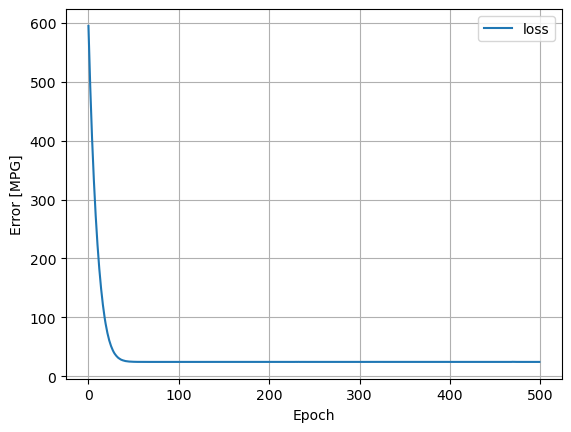

In [15]:
plot_loss(history)

### Visualise the TensorFlow Linear Regression model
Let's visualise the model. I've written a function below that will plot the original data and the predicted values

In [16]:
def plot_horsepower(x, y):
  plt.scatter(X_train, y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

Let's view the model

8/8 [==============================] - 0s 2ms/step


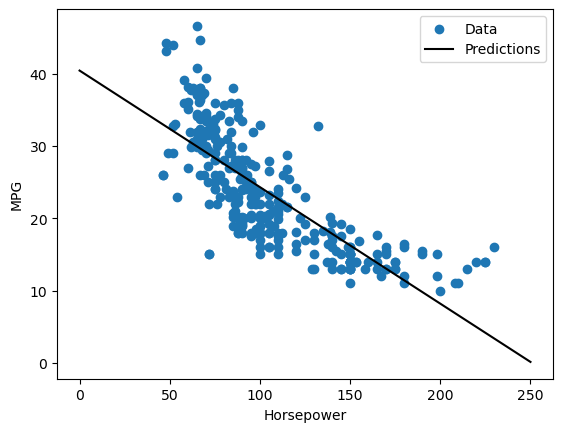

In [17]:
x = np.linspace(0.0, 250, 251)
y_pred = model.predict(x)
plot_horsepower(x,y_pred)

## Model 2: Linear Regression with sklearn
Let's try to fit a model with SKLearn's Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression
model_sk = LinearRegression()
model_sk.fit(X_train.values.reshape(-1,1),y_train.values)
yPredSK = model_sk.predict(X_test.values.reshape(-1,1))

In [19]:
print(model_sk.coef_)
print(model_sk.intercept_)
sklearnLinearRegressionEval = mean_squared_error(y_test, yPredSK)
print("sklearn Linear Regression Loss: ", round(sklearnLinearRegressionEval,4))

[-0.16007745]
40.31638714059319
sklearn Linear Regression Loss:  22.57


Let's view the SKLearn model

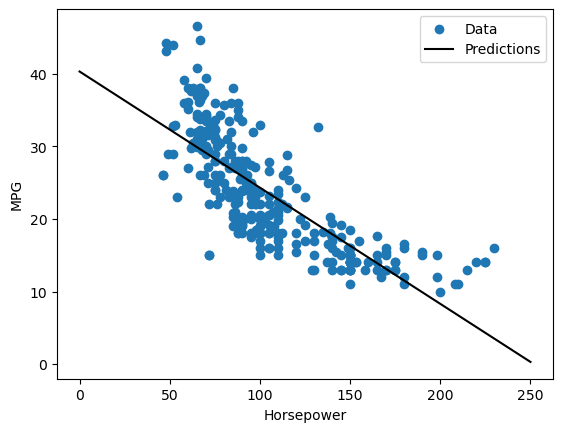

In [20]:
x = np.linspace(0.0, 250, 251)
y_pred = model_sk.predict(x.reshape(-1,1))
plot_horsepower(x,y_pred)

## Model 3: Regression with TensorFlow Neural Network

Now using a TensorFlow Neural Network

Going to go with two hidden layers with 64 units each
The output layer will only have 1 unit (as it is a regression problem)

In [21]:
modelNN = tf.keras.Sequential([
      horsepower_normalizer,
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

modelNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 1)                 3         
 on)                                                             
                                                                 
 dense_1 (Dense)             (None, 64)                128       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [22]:
modelNN.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

This time I've decided to use a validation set to evaluate the system at each epoch

Note that validation_split=0.2 takes the last 20% of the training data to be validation data, if I hadn't shuffled my data previously (using train_test_split) then I would need to now

In [23]:
historyNN = modelNN.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 25ms/step - loss: 619.5403 - val_loss: 585.8316
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 610.5802 - val_loss: 577.0743
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 600.7110 - val_loss: 566.6730
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 588.5406 - val_loss: 553.7601
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 573.7601 - val_loss: 536.9557
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 554.2658 - val_loss: 515.2235
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 529.3876 - val_loss: 487.7789
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 498.5733 - val_loss: 454.2147
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 461.7147 - val_loss: 414.3629
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 418.5713 - val_los

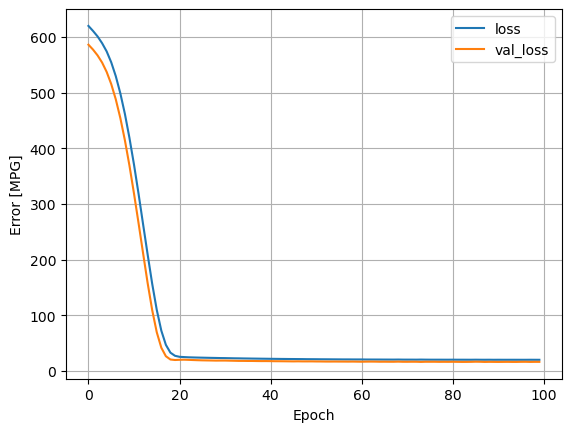

In [24]:
plot_loss(historyNN)

Again, let's visualise the ANN model

8/8 [==============================] - 0s 2ms/step


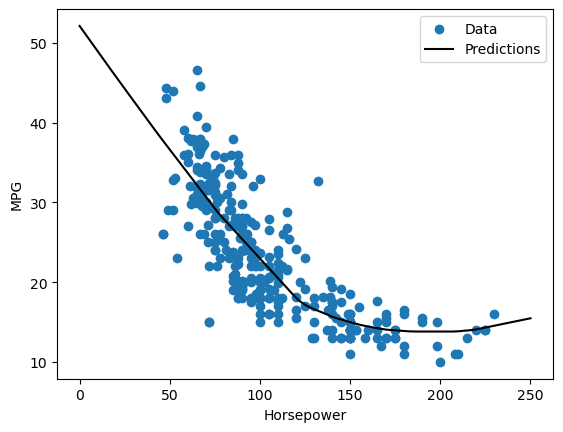

In [25]:
x = tf.linspace(0.0, 250, 251)
y = modelNN.predict(x)
plot_horsepower(x,y)

Notice the different shape

In [26]:
tfNNEval = modelNN.evaluate(X_test, y_test)
print("TensorFlow Linear Regression Loss: ", round(tfNNEval,4))

3/3 [==============================] - 0s 3ms/step - loss: 18.3551
TensorFlow Linear Regression Loss:  18.3551


In [27]:
print("Model 1: TensorFlow Linear Regression Loss: ", round(tfLinearRegressionEval,4))
print("Model 2: sklearn Linear Regression Loss: ", round(sklearnLinearRegressionEval,4))
print("Model 3: TensorFlow Linear Regression Loss: ", round(tfNNEval,4))

Model 1: TensorFlow Linear Regression Loss:  22.608
Model 2: sklearn Linear Regression Loss:  22.57
Model 3: TensorFlow Linear Regression Loss:  18.3551


The ANN gave the best score! The non-linear NN model better captured the underlying trend